In [52]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as tf
import torch.optim as optim

from utils import flow2rgb
from utils import rgb2gray
from utils import read_flo
from utils import read_image

from scipy.integrate import dblquad
from numpy.linalg import norm

In [53]:
def numpy2torch(array):
    """ Converts 3D numpy HWC ndarray to 3D PyTorch CHW tensor."""
    assert (array.ndim == 3)

    result = np.copy(array)
    result = np.moveaxis(result,[1,2,0],[2,0,1])
    result = torch.from_numpy(result)
    
    return result


In [54]:
a=np.ones([2,3,4]) #HWC -> CHW 312
a.shape

(2, 3, 4)

In [55]:
b=numpy2torch(a)
b.shape

torch.Size([4, 2, 3])

In [56]:
def torch2numpy(tensor):
    """ Convert 3D PyTorch CHW tensor to 3D numpy HWC ndarray."""
    assert (tensor.dim() == 3)

    result = tensor.clone().permute(1,2,0).numpy()
    return result

In [57]:
torch2numpy(b).shape

(2, 3, 4)

In [58]:
def load_data(im1_filename, im2_filename, flo_filename):
    """ Loads images and flow ground truth. Returns 4D tensors."""
    i0_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im1_filename
    i1_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im2_filename
    flo_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+flo_filename
    i0 = read_image(i0_path)
    i0 = rgb2gray(i0)
    i1 = read_image(i1_path)
    i1 = rgb2gray(i1)    
    tensor1 = numpy2torch(i0).view(1,1,i0.shape[0],i0.shape[1])
    tensor2 = numpy2torch(i1).view(1,1,i1.shape[0],i1.shape[1])
    flow_gt = numpy2torch(read_flo(flo_path)).view(1,2,i1.shape[0],i1.shape[1])

    return tensor1, tensor2, flow_gt

In [59]:
i0,i1,flo=load_data("frame10.png","frame11.png","flow10.flo")
flo.shape

torch.Size([1, 2, 388, 584])

In [60]:
def evaluate_flow(flow, flow_gt):
    """
    Evaluate the average endpoint error w.r.t the ground truth flow_gt.
    Excludes pixels, where u or v components of flow_gt have values > 1e9.
    """
    
    assert (flow.dim() == 4 and flow_gt.dim() == 4)
    assert (flow.size(1) == 2 and flow_gt.size(1) == 2)

    #u = flow[0,0,:,:] * flow[0,0,:,:].le(1e9).float()
    #v = flow[0,1,:,:] * flow[0,1,:,:].le(1e9).float()
    u = flow[0,0,:,:]
    v = flow[0,0,:,:]
    
    # Filter for invalid pixels
    u_gt = flow_gt[0,0,:,:] * flow_gt[0,0,:,:].le(1e9).float()
    v_gt = flow_gt[0,1,:,:] * flow_gt[0,1,:,:].le(1e9).float()

    # AEPE for each pixel
    errors = np.sqrt((u-u_gt)**2 + (v-v_gt)**2)
    
    print(errors)
    
    # Average over all pixels
    aepe = sum(sum(errors))/errors.nelement()

    return aepe

In [61]:
def warp_image(im, flow):
    """ Warps given image according to the given optical flow."""
    assert (im.dim() == 4 and flow.dim() == 4)
    assert (im.size(1) in [1,3] and flow.size(1) == 2)
    """
    # Permute dimensions and range of flow for grid_sample()
    flow = flow.permute(0,2,3,1)
    flow[0,:,:,0] /= torch.max(flow[0,:,:,0])
    flow[0,:,:,1] /= torch.max(flow[0,:,:,1])
    
    warped = torch.nn.functional.grid_sample(im,flow)
    """
    norm_flow = torch.Tensor(flow.permute(0,2,3,1))
    norm_flow[:,:,:,0] = norm_flow[:,:,:,0] / (norm_flow.size(1)-1) # normalize it to (0,1)
    norm_flow[:,:,:,1] = norm_flow[:,:,:,1] / (norm_flow.size(2)-1) # normalize it to (0,1)
    norm_flow = norm_flow*2 - 1 # bringing it to the range (-1,1) for the grid_sample function
    # interpolate the image with the flow
    warped = tf.grid_sample(im, norm_flow)
    return warped

In [62]:
def visualize_warping_practice(im1, im2, flow_gt):
    """ Visualizes the result of warping the second image by ground truth."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) in [1,3] and im2.size(1) in [1,3] and flow_gt.size(1) == 2)
    
    warped_im2 = warp_image(im2, flow_gt)
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Image 1")
    plt.imshow(im1[0,0,:,:], cmap="gray")
    plt.subplot(132)
    plt.title("Warped Image 2")
    plt.imshow(warped_im2[0,0,:,:], cmap="gray")
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow(im1[0,0,:,:]-warped_im2[0,0,:,:], cmap="gray")
    plt.show()
    
    return None

In [63]:
def energy_hs(im1, im2, flow, lambda_hs):
    """ Evalutes Horn-Schunck energy function."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow.size(1) == 2)
    
    
    """
    def grad_u(x,y): return np.gradient(flow[0,0,:,:])[x,y]
    def grad_v(x,y): return np.gradient(flow[0,1,:,:])[x,y]
    # TODO: Interpolate It1 and It0
    def It1(x,y): return warp_image(im2,flow)[0,0,x,y]
    def It0(x,y): return im1[0,0,x,y]

    def integral(x,y):
        return (It1(x,y)-It0(x,y))**2 + lambda_hs*(np.norm(grad_u)**2 + np.norm(grad_v)**2)
    
    energy = dblquad(integral, -np.inf, np.inf, -np.inf, np.inf)
    """
    
    # Use sum instead of integral (discrete pixels in picture)
    # TODO: use torch instead of numpy here
    It1 = warp_image(im2,flow)[0,0,:,:]
    It0 = im1[0,0,:,:]
    
    # TODO: use sobelfilter on u(x,y) and v(x,y)
    grad_u = ...
    grad_v = ...
    
    energy = 0
    for x in np.arange(0, np.shape(It1)[0]):
        for y in np.arange(0, np.shape(It1)[1]):
            energy += (It1[x,y]-It0[x,y])**2 + lambda_hs*(norm(grad_u[:,x,y])**2 + norm(grad_v[:,x,y])**2)
    return energy

In [64]:
def estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimate flow using HS with Gradient Descent.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow]
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    # Initial flow
    flow = torch.randn(1,2,flow_gt.size(2),flow_gt.size(3),requires_grad=True)
    
    for i in np.arange(0, num_iter):
        print("Iteration ", num_iter+1)
        # Forward pass
        # TODO: Warp im1 or im2??
        im2_estimate = warp_image(im1,flow)
        loss = energy_hs(im1, im2_estimate, flow, lambda_hs)
        # Backward pass
        loss.backward()
    
    print("Gradient Descent AEPE: ", evaluate_flow(flow, flow_gt))
    plt.figure()
    plt.title("Flow estimated with gradient descent")
    plt.imshow(flow2rgb(flow))
    plt.show()
        
    
    return

In [65]:
def estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimates flow using HS with LBFGS.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [66]:
def estimate_flow_coarse_to_fine(im1, im2, flow_gt, lambda_hs, learning_rate,
                                 num_iter, num_level):
    """
    Estimates flow using HS with LBFGS in a coarse-to-fine scheme.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [67]:
def problem2():

    # Loading data
    im1, im2, flow_gt = load_data("frame10.png", "frame11.png", "flow10.flo")


    # Parameters
    lambda_hs = 0.0015
    num_iter = 400

    # Warping_practice
    visualize_warping_practice(im1, im2, flow_gt)

    print("HS: ", energy_hs(im1,im2,flow_gt,lambda_hs))
    
    # Gradient descent
    learning_rate = 20
    estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    """
    # LBFGS
    learning_rate = 1
    estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    # Coarse to fine
    learning_rate = 1
    num_level = 4
    estimate_flow_coarse_to_fine(
        im1, im2, flow_gt, lambda_hs, learning_rate, num_iter, num_level)
    """

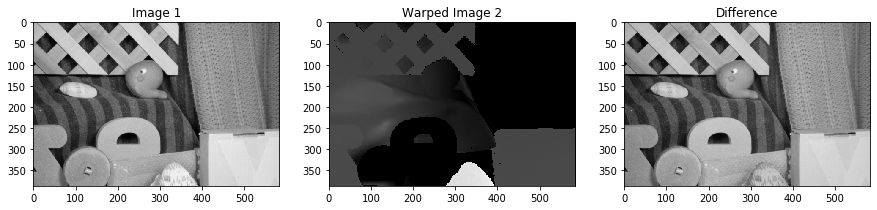

HS:  tensor(6.3713e+08)
Iteration  401


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [68]:
problem2()